## Joanna Piega 
# Praca domowa 5


# Budowa modeli

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
matplotlib.style.use('ggplot')
data = pd.read_stata("data.dta")

Zmienne, na podstawie których zostaną zbudowane modele to:
    * q26 - odpowiada za informację czy partnerzy byli studentami jednej uczelni
    * ppeducat - odpowiada za poziom wykształcenia
    * q24_met_online - czy partnerzy poznali się online
    * how_long_relationship - jak długo trwa związek
    * age_difference - jaka jest różnica wieku między partnerami

## Przekształcenie danych na dane numeryczne

In [3]:
data = data[["s1","age_difference","q26","ppeducat","q24_met_online","how_long_relationship"]]
data = data[data.isnull().sum(axis = 1) == 0]
data.q24_met_online = pd.Categorical(data.q24_met_online).codes
data.ppeducat = pd.Categorical(data.ppeducat).codes
data.q26 = pd.Categorical(data.q26).codes
data.s1 = pd.Categorical(data.s1).codes
#data.q16 = pd.Categorical(data.q16).codes

## Podział danych na zbiór treningowy i testowy

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,1:6],data.s1, test_size = 0.10, random_state = 0)

# Modele

Stworzę dwa modele oparte na tych samych zmiennych - model XGBoost oraz model logistyczny.

## Stworzenie modelu predykcyjnego - XGBoost

In [5]:
from xgboost import XGBClassifier
model_XGB = XGBClassifier(max_depth=10)
model_XGB.fit(X_train,Y_train)
y_pred_XGB = model_XGB.predict(X_test)

## Stworzenie modelu predykcyjnego - model logistyczny

In [6]:
from sklearn.linear_model import LogisticRegression
model_lin = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_lin.fit(X_train,Y_train)
y_pred_lin = model_lin.predict(X_test)

## Ocena jakości zbudowanych modeli

Accuracy w modelu XGB

In [7]:
from sklearn.metrics import accuracy_score
round(accuracy_score(Y_test, [round(i) for i in y_pred_XGB]),2)*100

72.0

Accuracy w modelu logistycznym

In [8]:
round(accuracy_score(Y_test, [round(i) for i in y_pred_lin]),2)*100

75.0

In [9]:
variables = ["age_difference","q26","ppeducat","q24_met_online","how_long_relationship"]

Funkcja do perturbacji - z uwagi, że mamy do czynienia ze zmiennymi ciągłymi i dyskretnymi - generuję perturbacje na dwa sposoby.
Dla zmiennej ciągłej będą to spermutowane wartości zmiennej ciągłe z szumem o rozkładzie standardowym normalnym
Dla zmiennej dyskretnej - jako że chcę trzymać najbardziej "pesymistyczny" przypadek - dla każdej z obserwacji losuję wartość zmiennej ze zbioru przyjmowanych wartości pomniejszonym o wartość danej obserwacji w oryginalnym zbiorze danych (tak żeby wartość zmiennej po perturbacji była różna od wartości w oryginalnym zbiorze)

In [40]:
def pert(var, data):
    data_pert=data.copy()
    n = data.shape[0]
    if len(pd.unique(data[var])) > 3:
        data_pert[var] = [round(abs(i),1) for i in [(list(data[var][np.random.permutation(data[var].index)])[i]+np.transpose([np.random.normal(loc = 0, scale = np.std(data[var]), size = n)])[i])[0] for i in range(len(data[var]))]]
    else:
        data_pert[var] = [np.random.choice(list(set(np.unique(data[var]))-set([i])),1)[0] for i in data_pert[var]]
    return data_pert

In [60]:
acc_lin = list([round(accuracy_score(Y_test, [round(i) for i in y_pred_lin]),2)*100])
acc_XGB = list([round(accuracy_score(Y_test, [round(i) for i in y_pred_XGB]),2)*100])
for i in variables:
    df = pert(i,X_test)
    acc_lin.append(round(accuracy_score(Y_test, [round(i) for i in model_lin.predict(df)]),2)*100)
    acc_XGB.append(round(accuracy_score(Y_test, [round(i) for i in model_XGB.predict(df)]),2)*100)
acc_lin = [round(acc_lin[i]-acc_lin[0]) for i in range(1,len(acc_lin))]
acc_XGB = [round(acc_XGB[i] - acc_XGB[0]) for i in range(1,len(acc_XGB))]


In [61]:
def plot_loss(acc, title):
    fig, ax = plt.subplots()   
    width = 0.75 
    ind = np.arange(len(acc)) 
    colours = ["lightcoral" if v<0 else "lightgreen" for v in acc[::-1]]
    ax.barh(ind, acc[::-1], width, color=colours)
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(variables, minor=False)
    plt.title(title)
    plt.xlabel('loss of accuracy %')
    plt.ylabel('variable')   
    for i in range(len(acc)):
        ax.text(2.95, i - .1, acc[::-1][i], color='darkblue', fontweight='bold')
    plt.show()


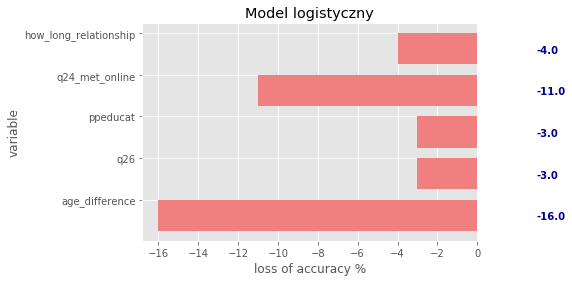

In [62]:
plot_loss(acc_lin, "Model logistyczny")

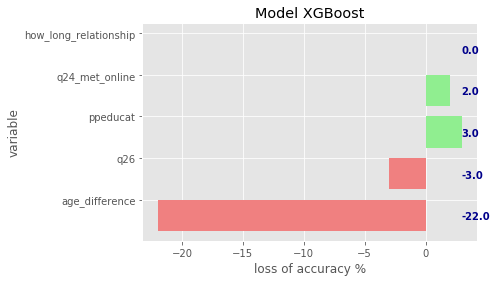

In [63]:
plot_loss(acc_XGB, "Model XGBoost")

## Wnioski po perturbacji

Biorąc pod uwagę, że eksperyment z perturbacją wykonujemy tylko raz - nie mamy podstaw by sądzić, że zmienne how_long_relationship, pp_educat oraz q26 są zmiennymi w znaczący sposób wpływającymi na predykcję obu modeli. Być może należałoby wykonać perturbację większą liczbę razy i następnie uśrednić wyniki - jednak nie to było celem naszego doświadczenia. Na podstawie wykresów można wywnioskować, że w obu modelach istotną zmienną jest zmienna "age_difference", ponieważ po jej perturbacji znacznie spada jakość dopasowania obu modeli. Ciekawym zjawiskiem jest jednak fakt, że perturbacja zmiennej q24_met_online znacząco obniża jakość predykcji modelu logistycznego, a w przypadku modelu XGBoost - niewiele zmienia. Przyjrzymy się zatem tej zmiennej na wykresie PDP.

In [77]:
def PD(model1, model2, index, points, X):
    Tab=X.copy()
    prob=list()
    for point in points:
        Tab.iloc[:,index]=[point]*Tab.shape[0]
        prob.append(pd.DataFrame(model1.predict_proba(Tab)).iloc[:,0].mean())
    plt.plot(points, prob)
    Tab=X.copy()
    prob=list()
    for point in points:
        Tab.iloc[:,index]=[point]*Tab.shape[0]
        prob.append(pd.DataFrame(model2.predict_proba(Tab)).iloc[:,0].mean())
    plt.plot(points, prob)
    plt.legend(('model logistyczny', 'XGBoost'))
    plt.show()

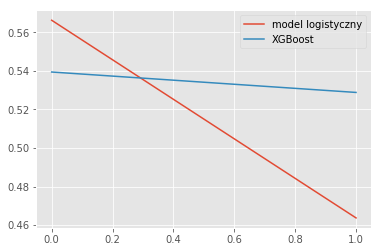

In [78]:
PD(model_lin, model_XGB,3,[0,1],X_test)


Krzywe PDP dla zmiennej q24_met_online potwierdzają istotny wpływ na predykcję dla modelu logistycznego, zaś niewielki dla modelu XGBoost.